# Diffusion properties

## Import libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections
import os
import sys
sys.path.append("../")

from scipy import stats
from scipy.linalg import norm
from scipy.optimize import curve_fit

from config import results_folder, plots_folder

## Parameters

In [47]:
N = 2000
radius = 0.007
v0 = 0.2

## Utility functions

In [91]:
def msd_function(t, v0, q, gamma):
    #v0 = 0.2
    return (v0**2-q/gamma)*(1-np.exp(-gamma*t))**2/gamma**2+2*q*t/gamma**2-2*q*(1-np.exp(-gamma*t))/gamma**3

def msd_function_v0(t, q, gamma):
    v0 = 0.2
    #v0 = 0.1784
    return (v0**2-q/gamma)*(1-np.exp(-gamma*t))**2/gamma**2+2*q*t/gamma**2-2*q*(1-np.exp(-gamma*t))/gamma**3

def msd_function_given_ratio(t, gamma):
    ratio = 0.04
    return 2*ratio*t/gamma -2 * ratio*(1-np.exp(-gamma*t))/gamma**2

def msd_function_v0_higher_mass(t, q, gamma):
    v0 = 0.2/np.sqrt(3)
    return (v0**2-q/gamma)*(1-np.exp(-gamma*t))**2/gamma**2+2*q*t/gamma**2-2*q*(1-np.exp(-gamma*t))/gamma**3

In [17]:
def lin_fit(mean_q_dist_matrix):
    times = mean_q_dist_matrix[:, 0]
    values = mean_q_dist_matrix[:, 1]
    lin_fit_times = times[100:]
    lin_fit_values = values[100:]
    slope, intercept, r_value, p_value, std_err = stats.linregress(lin_fit_times, lin_fit_values)
    return slope, intercept

def adjust_curve(mean_q_dist_matrix, msd_func):
    times = mean_q_dist_matrix[:, 0]
    values = mean_q_dist_matrix[:, 1]
    popt, pcov = curve_fit(msd_func, times, values)
    return popt

In [5]:
D = 7.88*1e-04
avg_speed = 0.177

## Mean quadratic displacement as a function of time
Have looked at the particle closest to the center. Have looked at the different cases

### Equal particles

In [6]:
# mean_q_dist_matrix_ep = np.load(file=os.path.join(results_folder, f"diffProperties_r0m0_particle_tmax_1_runs_1.npy"))
mean_q_dist_matrix_ep_avg = np.load(file=os.path.join(results_folder, f"diffProperties_r0m0_particle_tmax_5_runs_200.npy"))
times = mean_q_dist_matrix_ep_avg[:, 0]

In [7]:
slope, intercept = lin_fit(mean_q_dist_matrix_ep_avg)
popt = adjust_curve(mean_q_dist_matrix_ep_avg, msd_function)
popt_2 = adjust_curve(mean_q_dist_matrix_ep_avg, msd_function_v0)

In [8]:
popt

array([0.09406911, 0.01420862, 2.40349753])

In [9]:
popt_2

array([ 0.31306647, 11.72532253])

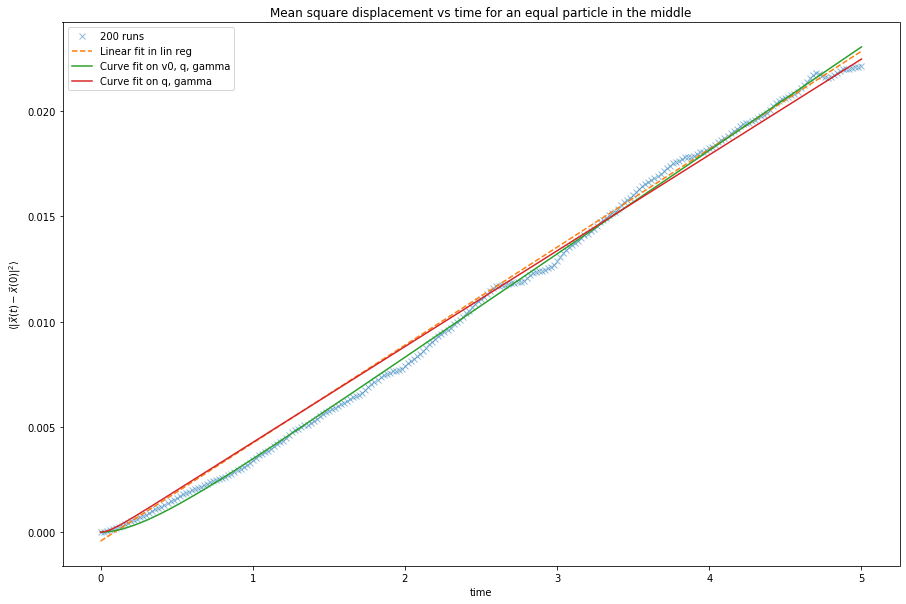

In [10]:
plt.figure(figsize=(15, 10))
#plt.plot(times, mean_q_dist_matrix_ep[:, 1], 'o', alpha=0.5, label='Single run')
plt.plot(times, mean_q_dist_matrix_ep_avg[:, 1], 'x', alpha=0.5, label='200 runs')
plt.plot(times, times*slope+intercept, '--', label='Linear fit in lin reg')
plt.plot(times, msd_function(times, *popt), label='Curve fit on v0, q, gamma')
plt.plot(times, msd_function_v0(times, *popt_2), label='Curve fit on q, gamma')
plt.xlabel('time')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}(0)|^2\rangle$')
plt.title('Mean square displacement vs time for an equal particle in the middle')
plt.legend()
plt.show()

## Middle particle has m=3m0

In [11]:
#mean_q_dist_matrix_3m0 = np.load(file=os.path.join(results_folder, f"diffProperties_3m0_particle_tmax_1_runs_1.npy"))
mean_q_dist_matrix_3m0_avg = np.load(file=os.path.join(results_folder, f"diffProperties_r03m0_particle_tmax_5_runs_200.npy"))
times = mean_q_dist_matrix_3m0_avg[:, 0]

In [12]:
slope, intercept = lin_fit(mean_q_dist_matrix_3m0_avg)
popt = adjust_curve(mean_q_dist_matrix_3m0_avg, msd_function)
popt_2 = adjust_curve(mean_q_dist_matrix_3m0_avg, msd_function_v0_higher_mass)

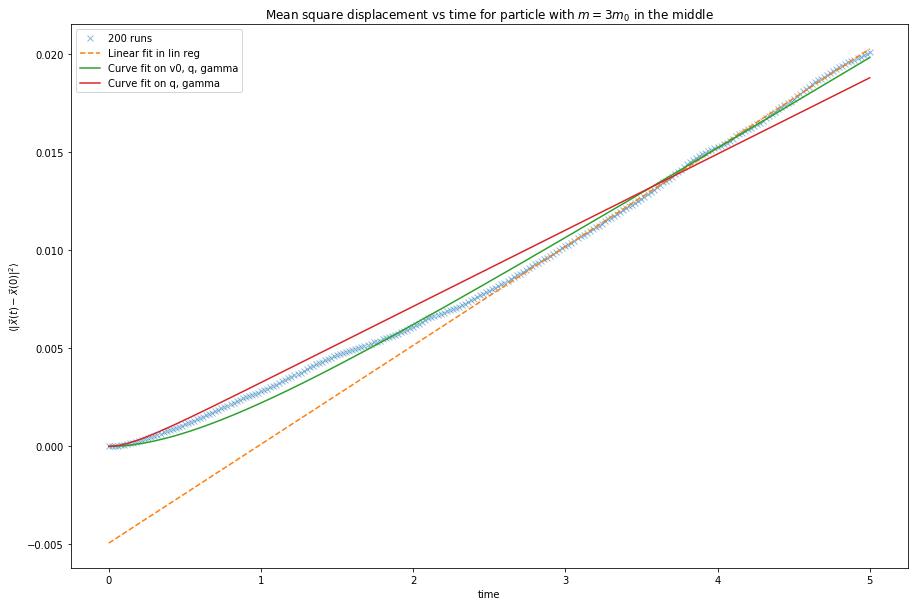

In [13]:
plt.figure(figsize=(15, 10))
# plt.plot(times, mean_q_dist_matrix_3m0[:, 1], 'o', alpha=0.5, label='Single run')
plt.plot(times, mean_q_dist_matrix_3m0_avg[:, 1], 'x', alpha=0.5, label='200 runs')
plt.plot(times, times*slope+intercept, '--', label='Linear fit in lin reg')
plt.plot(times, msd_function(times, *popt), label='Curve fit on v0, q, gamma')
plt.plot(times, msd_function_v0_higher_mass(times, *popt_2), label='Curve fit on q, gamma')
# plt.plot(times, times*4*D)
plt.xlabel('time')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}(0)|^2\rangle$')
plt.title(r'Mean square displacement vs time for particle with $m=3m_0$ in the middle')
plt.legend()
plt.show()

### Brownian particle: r=3r0

In [14]:
#mean_q_dist_matrix_bp = np.load(file=os.path.join(results_folder, f"diffProperties_3r0bp_particle_tmax_1_runs_1.npy"))
mean_q_dist_matrix_bp_avg = np.load(file=os.path.join(results_folder, f"diffProperties_3r0m0_particle_tmax_5_runs_200.npy"))
times = mean_q_dist_matrix_bp_avg[:, 0]

In [15]:
slope, intercept = lin_fit(mean_q_dist_matrix_bp_avg)
popt = adjust_curve(mean_q_dist_matrix_bp_avg, msd_function)
popt_2 = adjust_curve(mean_q_dist_matrix_bp_avg, msd_function_v0)

In [16]:
popt

array([0.04864593, 0.00163349, 0.99890284])

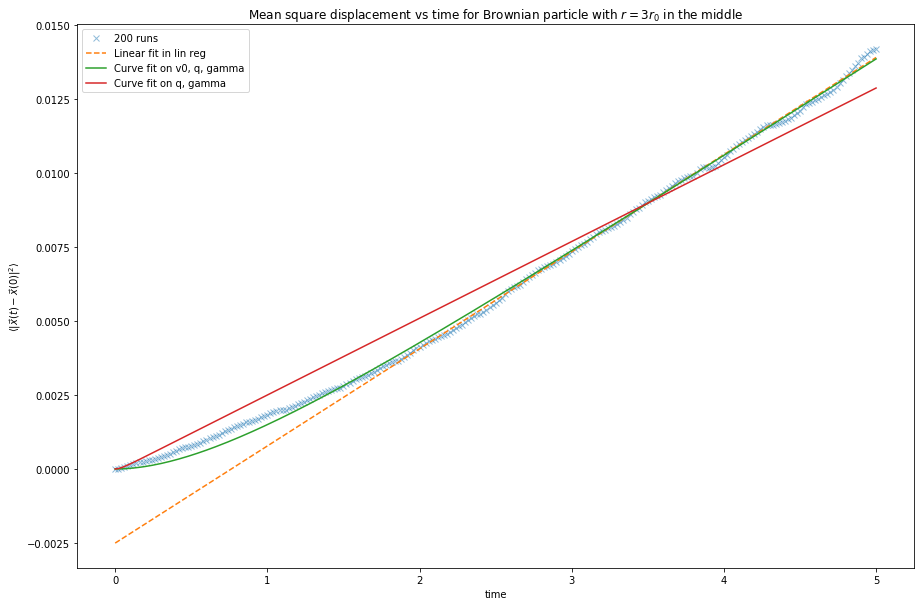

In [17]:
plt.figure(figsize=(15, 10))
#plt.plot(times, mean_q_dist_matrix_bp[:, 1], 'o', alpha=0.5, label='Single run')
plt.plot(times, mean_q_dist_matrix_bp_avg[:, 1], 'x', alpha=0.5, label='200 runs')
plt.plot(times, times*slope+intercept, '--', label='Linear fit in lin reg')
plt.plot(times, msd_function(times, *popt), label='Curve fit on v0, q, gamma')
plt.plot(times, msd_function_v0(times, *popt_2), label='Curve fit on q, gamma')
# plt.plot(times, times*4*D)
plt.xlabel('time')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}(0)|^2\rangle$')
plt.title(r'Mean square displacement vs time for Brownian particle with $r=3r_0$ in the middle')
plt.legend()
plt.show()

### Test

In [101]:
mean_q_dist_matrix_ep = np.load(file=os.path.join(results_folder, f"diffProperties_r0m0_particle_tmax_5_runs_20.npy"))
mean_q_dist_matrix_ep_eq = np.load(file=os.path.join(results_folder, f"diffProperties_r0m0_particle_tmax_3_runs_20_eq_start.npy"))
times = mean_q_dist_matrix_ep[:, 0]

In [102]:
slope, intercept = lin_fit(mean_q_dist_matrix_ep)
popt = adjust_curve(mean_q_dist_matrix_ep, msd_function)
popt_2 = adjust_curve(mean_q_dist_matrix_ep, msd_function_v0)
popt_3 = adjust_curve(mean_q_dist_matrix_ep, msd_function_given_ratio)

In [103]:
popt  # optimal parameters given as v0, q, gamma

array([0.10852047, 0.02309535, 3.20767756])

In [104]:
popt_2  # optimal parameters given as q, gamma

array([ 0.33262913, 12.46136648])

In [105]:
popt_3  # optimal parameters given as gamma when assume equilirium and q/gamma = 0.04

array([18.71295088])

In [106]:
popt[1]/popt[2] # garbadge ?

0.007200021644682628

In [107]:
kT = 0.02  # average kinetic energy
gamma = 4*kT/slope  # relation from eq. 4b in GG, where slope for t -> inf is 2q/gamma^2
q = 2*gamma*kT  # relation from http://web.phys.ntnu.no/~ingves/Teaching/TFY4275/Downloads/kap6.pdf

In [108]:
print(gamma, q, q/gamma) # q/gamma is equal to v^2(t to inf) and v0^2 when all start with the same energy

17.211831404428356 0.6884732561771343 0.04


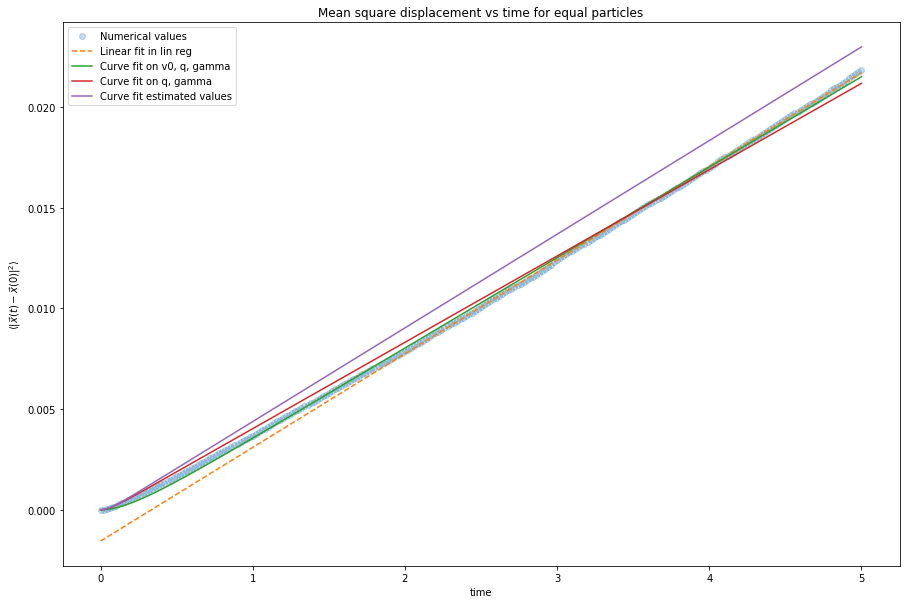

In [109]:
plt.figure(figsize=(15, 10))
plt.plot(times, mean_q_dist_matrix_ep[:, 1], 'o', alpha=0.25, label='Numerical values')
plt.plot(times, times*slope+intercept, '--', label='Linear fit in lin reg')
plt.plot(times, msd_function(times, *popt), label='Curve fit on v0, q, gamma')
plt.plot(times, msd_function_v0(times, *popt_2), label='Curve fit on q, gamma')
#plt.plot(times, msd_function_given_ratio(times, *popt_3), label='Curve fit on gamma in eq.')
plt.plot(times, msd_function_v0(times, q, gamma), label='Curve fit estimated values')
#plt.plot(mean_q_dist_matrix_ep_eq[:, 0], mean_q_dist_matrix_ep_eq[:, 1], 'o', alpha=0.25, label='Numerical values eq start')
#plt.plot(times, 2*q/gamma**2 * times - 2*q/gamma**3 *(1-np.exp(-gamma*times)), label='Curve fit estimate values 2')
plt.xlabel('time')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}(0)|^2\rangle$')
plt.title(r'Mean square displacement vs time for equal particles')
plt.legend()
plt.show()

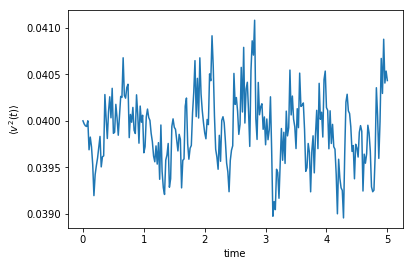

In [110]:
plt.plot(times, mean_q_dist_matrix_ep[:, 2])
plt.xlabel('time')
plt.ylabel(r'$\langle v^2(t) \rangle$')
plt.show()

Comment on results:
- The numerical values look to be linear for large t and quadratic for small t -> good!
- The green line is the best fit, where v0 is not thought to be what it really is -> not good
- The red line is the same as green when one use correct value for v0. Does not seem to capture the linear trend for large t, but maybe is it the most correct anyways? Would become better if simulation were run for a longer time?
- Purple line is based on parameters estimated from the slope of the linear fit of the late values. The ratio of q and gamma are automatically correct using the given relations. However the line seems to be a off with a constant value. However this is possibly due to the fact that the estimated values arise from an equilibrium position, which is not the case in the beginning. Therefore this line would maybe be completely correct if starting the simulation from an equilibrium position. This is not easy when the particles are not identical... What to do? The constant offset seem to argue that one has gotten the correct equilirbium development at least since the linear fit and this line seem to be parallell.

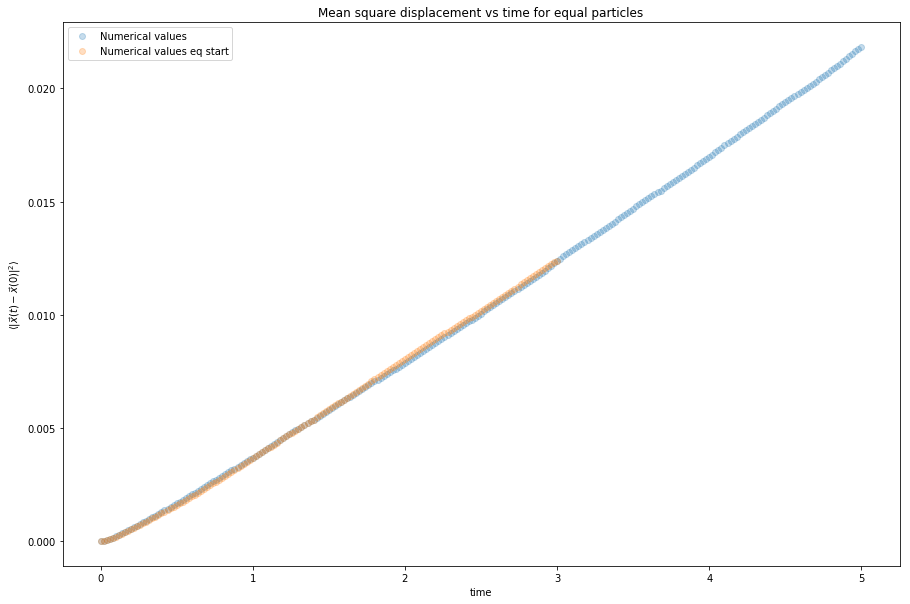

In [111]:
plt.figure(figsize=(15, 10))
plt.plot(times, mean_q_dist_matrix_ep[:, 1], 'o', alpha=0.25, label='Numerical values')
#plt.plot(times, times*slope+intercept, '--', label='Linear fit in lin reg')
#plt.plot(times, msd_function(times, *popt), label='Curve fit on v0, q, gamma')
#plt.plot(times, msd_function_v0(times, *popt_2), label='Curve fit on q, gamma')
#plt.plot(times, msd_function_given_ratio(times, *popt_3), label='Curve fit on gamma in eq.')
#plt.plot(times, msd_function_v0(times, q, gamma), label='Curve fit estimated values')
plt.plot(mean_q_dist_matrix_ep_eq[:, 0], mean_q_dist_matrix_ep_eq[:, 1], 'o', alpha=0.25, label='Numerical values eq start')
#plt.plot(times, 2*q/gamma**2 * times - 2*q/gamma**3 *(1-np.exp(-gamma*times)), label='Curve fit estimate values 2')
plt.xlabel('time')
plt.ylabel(r'$\langle|\vec{x}(t)-\vec{x}(0)|^2\rangle$')
plt.title(r'Mean square displacement vs time for equal particles')
plt.legend()
plt.show()

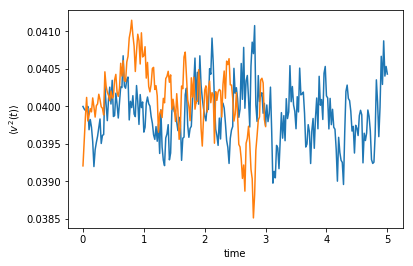

In [112]:
plt.plot(times, mean_q_dist_matrix_ep[:, 2])
plt.plot(mean_q_dist_matrix_ep_eq[:, 0], mean_q_dist_matrix_ep_eq[:, 2], label='Eq start')
plt.xlabel('time')
plt.ylabel(r'$\langle v^2(t) \rangle$')
plt.show()